# VeloVI Runtime Analysis

## Download Data

Using data from https://github.com/pachterlab/MBLGLMBHGP_2021/blob/master/notebooks/retina_velocity.ipynb.

In [2]:
# !wget -O retina.h5ad.gz https://caltech.box.com/shared/static/lo6satyyrjhvhgkmj3gv39360eshxa3n.gz

--2022-07-25 12:02:08--  https://caltech.box.com/shared/static/lo6satyyrjhvhgkmj3gv39360eshxa3n.gz
Resolving caltech.box.com (caltech.box.com)... 107.152.29.197
Connecting to caltech.box.com (caltech.box.com)|107.152.29.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/lo6satyyrjhvhgkmj3gv39360eshxa3n.gz [following]
--2022-07-25 12:02:08--  https://caltech.box.com/public/static/lo6satyyrjhvhgkmj3gv39360eshxa3n.gz
Reusing existing connection to caltech.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://caltech.app.box.com/public/static/lo6satyyrjhvhgkmj3gv39360eshxa3n.gz [following]
--2022-07-25 12:02:08--  https://caltech.app.box.com/public/static/lo6satyyrjhvhgkmj3gv39360eshxa3n.gz
Resolving caltech.app.box.com (caltech.app.box.com)... 74.112.186.144
Connecting to caltech.app.box.com (caltech.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Fo

In [3]:
# !gunzip retina.h5ad.gz

## Imports

In [1]:
import time
import random
import itertools
import os

import anndata
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch

import scvelo as scv
from velovi import VELOVI

Global seed set to 0


## Helper Definitions

In [2]:
def fit_scvelo(adata):
    start = time.time()
    scv.tl.recover_dynamics(
        adata, fit_scaling=False, var_names=adata.var_names, n_jobs=8
    )
    scv.tl.velocity(adata, mode="dynamical")
    return time.time() - start

def fit_velovi(bdata):
    start = time.time()
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata)
    vae.train()

    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={'elbo_train': 'elbo'})
    df['set'] = 'train'

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={'elbo_validation': 'elbo'})
    _df['set'] = 'validation'

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    # with mplscience.style_context():
    #     sns.set_style(style="whitegrid")
    #     fig, ax = plt.subplots(figsize=(6, 4))
    #     sns.lineplot(data=df, x='epoch', y='elbo', hue='set', palette=['#0173B2', '#DE8F05'], ax=ax)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocities_velovi"] = velocities / scaling
    bdata.layers["latent_time_velovi"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var['fit_scaling'] = 1.0

    return time.time() - start

In [3]:
def min_max_scaled(bdata):
    mu_scaler = MinMaxScaler()
    bdata.layers['Mu'] = mu_scaler.fit_transform(bdata.layers['Mu'])
    ms_scaler = MinMaxScaler()
    bdata.layers['Ms'] = ms_scaler.fit_transform(bdata.layers['Ms'])
    return bdata
 

In [4]:
def subsample_adata(adata, n):
  if n > adata.n_obs:
    print(f"{n} greater than n_obs, {adata.n_obs}. Using {adata.n_obs} instead.")
    n = adata.n_obs
  sample_idxs = np.random.choice(adata.n_obs, size=n, replace=False)
  sample_adata = adata[sample_idxs].copy()
  return sample_adata

## Run tests

In [5]:
adata = anndata.read_h5ad("retina.h5ad")
adata

AnnData object with n_obs × n_vars = 113909 × 5000
    obs: 'sample', 'time', 'barcode', 'umap_cluster', 'umap_coord1', 'umap_coord2', 'umap_coord3', 'used_for_pseudotime', 'umap2_CellType', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'neighbors', 'pca', 'umap2_CellType_colors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_pca', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

In [6]:
def run_runtime_tests(adata, subsample_ns):
  methods = ["scvelo", "velovi"]
  configs = list(itertools.product(methods, subsample_ns))
  random.shuffle(configs)
  for method_name, subsample_n in configs:
    save_name = f"results/{method_name}_{subsample_n}"
    if os.path.exists(save_name):
      print(f"{save_name} already exists, skipping")
      continue

    print(f"Running {method_name} with subsample_n={subsample_n}.")
    bdata = subsample_adata(adata, subsample_n)
    if method_name == "scvelo":
      runtime_s = fit_scvelo(bdata)
    elif method_name == "velovi":
      bdata = min_max_scaled(bdata)
      runtime_s = fit_velovi(bdata)
    else:
      raise ValueError
    
    res_row = [subsample_n, runtime_s, method_name]
    np.save(save_name, np.array(res_row))

In [7]:
run_runtime_tests(adata, subsample_ns=[1000, 5000, 10000, 20000, 50000, 100000])

Running scvelo with subsample_n=5000.
recovering dynamics (using 8/20 cores)


  0%|          | 0/5000 [00:00<?, ?gene/s]

    finished (0:02:47) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:08) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Running velovi with subsample_n=20000.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 114/500:  23%|██▎       | 114/500 [02:55<09:55,  1.54s/it, loss=-2.33e+04, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -22688.932. Signaling Trainer to stop.
Running velovi with subsample_n=10000.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 123/500:  25%|██▍       | 123/500 [01:35<04:52,  1.29it/s, loss=-2.29e+04, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -21790.102. Signaling Trainer to stop.
Running scvelo with subsample_n=100000.
recovering dynamics (using 8/20 cores)


  0%|          | 0/5000 [00:00<?, ?gene/s]

: 

: 

## Plotting

In [23]:
import glob

runtime_result_files = glob.glob("results/**.npy")
res_df_rows = []
for res_file in runtime_result_files:
    res_df_row = np.load(res_file)
    res_df_rows.append(res_df_row)
res_df = pd.DataFrame(res_df_rows, columns=['n_obs', 'runtime', 'method'])

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (4, 4)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


plt.rcParams["font.size"] = 11
plt.rcParams['font.sans-serif'] = ['Helvetica', "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams['font.weight'] = 500

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['xtick.minor.size'] = 1.375
plt.rcParams['xtick.major.size'] = 2.75
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2

plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['ytick.minor.size'] = 1.375
plt.rcParams['ytick.major.size'] = 2.75
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['ytick.minor.pad'] = 2

plt.rcParams["legend.fontsize"] = 12
plt.rcParams['legend.handlelength'] = 1.4
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 3
plt.rcParams['legend.frameon'] = False

plt.rcParams['lines.linewidth'] = 1.7

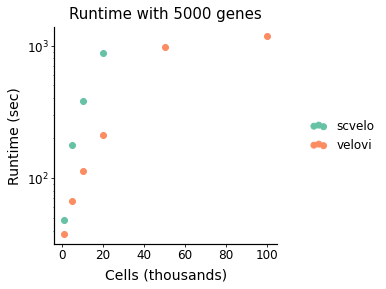

In [37]:
fig, ax = plt.subplots()

group = np.unique(res_df['method'])
palette = itertools.cycle(sns.color_palette("Set2"))

for g in np.unique(group):
    tmp = res_df[res_df['method']==g]
    tmp['n_obs'] = tmp['n_obs'].astype(int) // 1e3
    ax.scatter(tmp['n_obs'], tmp['runtime'].astype(float), label=g, color=next(palette))

ax.set_xlabel('Cells (thousands)')
ax.set_ylabel('Runtime (sec)')
ax.set_yscale('log')
ax.set_title('Runtime with 5000 genes')
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
# plt.show()
plt.savefig('figures/retina_runtime.pdf', bbox_inches='tight', dpi=300)
